In [2]:
from astropy.io import fits
from IPython.display import Image
import pytwr
%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [3]:
from platform import python_version

print(python_version())

3.8.5


In [4]:
#!/usr/bin/env python
# coding: utf-8

# # pydisc Notebook - 1.0

# ## 1 - Introduction

# *pydisc* is a python package meant to ease the use the manipulation of maps and profiles and the computation of basic quantities pertaining to galactic Discs. In this Notebook, I will show you how to use the main functionalities of *pydisc*.

# ## 2 - Structures in *pydisc*

# ### DataMaps, DataProfiles, Maps and Profiles

# In the language of *pydisc*:
# - **DataMaps** are data on a grid (hence 2D), e.g., values like velocities, flux, etc. The grid on which it is defined should be regular.
# - **DataProfiles** are data on a radial profile (hence 1D).
# - **Maps** are then a **set of** *DataMaps* associated with a set of coordinates X, Y.
# - **Profiles** are then a **set of** *DataProfiles* associated with a set of radial coordinates R.
# 
# DataMaps have orientations defined as 'NE_direct' indicating if the North-to-East axis is direct (counter-clockwise) or indirect (clockwise). It also has an 'alpha_North' angle which provides the angle between the North and the top (positive y-axis). DataMaps also have a pixelscale which provides the conversion between arcseconds and pixels in case the X,Y grids are not defined. If this is the case, X, and Y will be computed using just the indices from the grid.
# 
# DataMaps and DataProfiles have 'units' as defined by astropy units. These should be compatible with e.g., arcseconds, so these are observational. 
# 
# DataMap arguments:
# - dunit: astropy unit
# - order: velocity moment order. Hence velocities are order=1, flux or mass is 0, dispersion is 2, anything else would be -1 and there is a category for "dummy" maps with order=-10.
# - dname: name of the datamap
# - flag: a flag which is meant to add info (string)
# - data and edata: numpy arrays. If edata is not provided, it will be defined as None.
# 
# DataProfiles have similar arguments, but with punit (profile unit) and pname.
# 
# Maps arguments:
# - name: name of the map
# - X and Y: the 2 main arrays. If not provided, indices will be used.
# - Xcen and Ycen: centre for the 0,0
# - XYunit: unit (astropy) for the X and Y axis
# - NE_direct, alpha_North, etc.
# 
# Note that a Map can have many datamaps: hence a set of X,Y can have many data associated to it (sharing the same coordinates), each one having a different dname, order, flag etc.

# ### Galaxy

# A 'Galaxy' is an object which has some characteristics like: a distance, a Position Angle for the line of Nodes, an inclination (in degrees) and the Position Angle for a bar if present.

# ### GalacticDisc

# A 'GalacticDisc' is a structure associating a set of Maps and Profiles and a given Galaxy. 
# 
# This is the main structure which we will be using for the calculation of various quantities. 
# 
# There are a number of associated classes, namely:
# - 'DensityWave': associated with methods for density waves like the Tremaine Weinberg method
# - 'GalacticTorque': associated with methods for deriving torques
# 
# all inheriting from the GalacticDisc class, thus sharing a number of functionalities, but also have their own specific ones (which require a set of maps).
#     
# The 'grammar' for maps and datamaps is simple (a priori):
# - if you have an attribute like "data" you can input this in the argument list as:
# "data<map_name>_<datamap_name>". Hence if the map is name "MUSE" and the datamap named "vstar" you should have an argument for the data as "dataMUSE_vstar" and the associated "edataMUSE_vstar" if you have uncertainties for this map etc. Same applies for all argument of the maps and data, for example (using the same example): orderMUSE_vstar, XMUSE, YMUSE, XcenMUSE, YcenMUSE, flagMUSE_vstar...
# - In this way you can have several datamaps attached to a single map and have e.g.,: XMUSE, YMUSE, dataMUSE_vstar, dataMUSE_gas, dataMUSE_...
# 

# # 3- Examples

# ## 3.1 - Tremaine Weinberg

# Here is an example of how to get a Tremaine-Weinberg calculation made on a set of maps using the *DensityWave* class.

# In[13]:


# Importing the package and the DensityWave class
import src.pydisc as pydisc
from src.pydisc.density_wave import DensityWave

# Importing useful modules 
from astropy.io import fits as pyfits
from os.path import join as joinpath
import numpy as np

In [5]:
D = 4.1 # Mpc, thus dist_scale = 0.019877360925490 kpc/arcsec

bima_scale = 1. # arcsec/pix

pix_kpc = bima_scale*0.019877360925490 # kpc/pix

PA = 112. # deg

image_center = ( 180, 162) # image center in pix

incl = 60. # deg

v_syst = 408. # km/s, see Table 1 in arxiv.org/pdf/astro-ph/0304294.pdf

In [6]:
fname = './data/NGC4826.bima12m.gmom1.fits'
mom1data = fits.getdata(fname)
mom1data[np.isnan(mom1data)] = 0.

fname = './data/NGC4826.bima12m.mmom0.fits'
mom0data = fits.getdata(fname)
mom0data[np.isnan(mom0data)] = 0.000000001
mom0data[mom0data < 0.] = 0.000000001


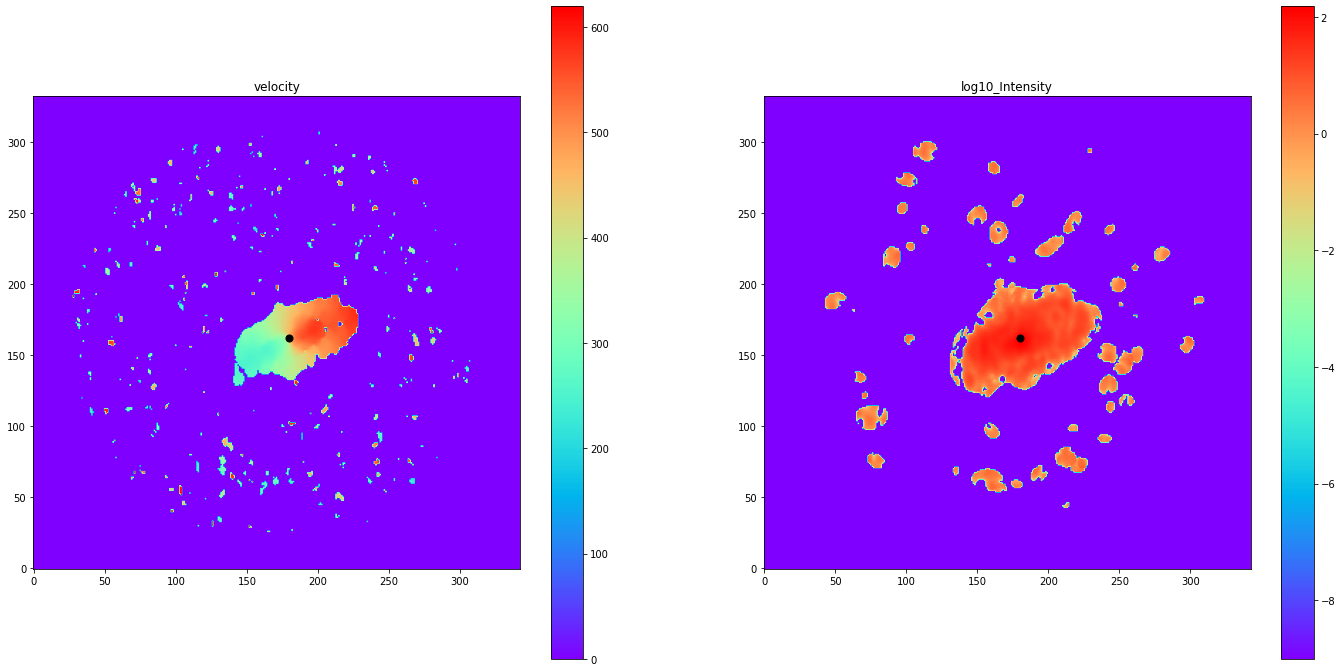

(1, 1, 333, 343)

In [7]:
fig = plt.figure(figsize=[24,12])
ax = plt.subplot(121)
im = ax.imshow(np.squeeze(mom1data), origin='lower', cmap='rainbow')
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('velocity')

ax = plt.subplot(122)
im = plt.imshow(np.squeeze(np.log10(mom0data)), origin='lower', cmap='rainbow')
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('log10_Intensity')

plt.show()
shape(mom0data)

In [8]:
plane_v = np.zeros((343, 333))
plane_intens = np.zeros((343, 333))
plane_v = pytwr.rotate_image(mom1data[0,0,:,:], angle=112.+270., center=image_center)
plane_intens = pytwr.rotate_image(mom0data[0,0,:,:], angle=112.+270, center=image_center)

In [9]:
plane_v = mom1data[0,0,:,:]
plane_intens = mom0data[0,0,:,:]

In [10]:
plane_v = plane_v - v_syst
plane_v[plane_v < -v_syst+0.001] = 0. # to keep all pixs with zero signal

In [11]:
# Getting the data
# ddata = "/home/science/PHANGS/MUSE/MUSEDAP/"
# n1512 = "NGC1512_MAPS.fits"
# Open the Maps files
# maps = pyfits.open(joinpath(ddata, n1512))
# Extract the mass, flux, and velocity maps
# mass = maps['STELLAR_MASS_DENSITY'].data
# flux = maps['FLUX'].data
# vel = maps['V_STARS'].data

mass = plane_intens
flux = plane_intens
vel = plane_v

In [12]:
# In[14]:


# mname is for mapname. 
mydisc = DensityWave(data_flux=flux, edata_flux=np.zeros_like(flux),
                     data_mass=mass, data_vel=vel, edata_vel=np.zeros_like(vel),
                     mname="N4826", Xcen=image_center[0], Ycen=image_center[1], PAnodes=90, distance=D, inclin=incl)

INFO: Attaching datamap flux of type INT (unit = solLum)
INFO: Attaching datamap mass of type INT (unit = solMass)
INFO: Attaching datamap vel of type NA (unit = km / s)
INFO: attaching map N4826


In [13]:
# In[15]:


# We can now look at the structure itself. 'mydisc' has a one map, which is named 'MUSE'. 
# This map is in a dictionary and is a Map class, as shown when printing it.
mydisc.maps

{'N4826': <src.pydisc.disc_data.Map at 0x7f25771e1670>}

In [14]:
# In[16]:


# We can also find out about the other variables:
mydisc.maps['N4826'].X

array([[-180., -179., -178., ...,  160.,  161.,  162.],
       [-180., -179., -178., ...,  160.,  161.,  162.],
       [-180., -179., -178., ...,  160.,  161.,  162.],
       ...,
       [-180., -179., -178., ...,  160.,  161.,  162.],
       [-180., -179., -178., ...,  160.,  161.,  162.],
       [-180., -179., -178., ...,  160.,  161.,  162.]], dtype=float32)

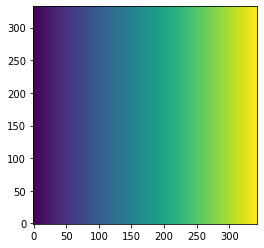

In [15]:
plt.imshow(mydisc.maps['N4826'].X, origin='lower')

In [16]:
# In[17]:


# This Map actually has datamaps as shown here, each one having data.
# You can see that this Map has actually three datamaps, one with flux, one with mass, the last one with vel.

mydisc.maps['N4826'].dmaps

{'flux': <src.pydisc.disc_data.DataMap at 0x7f25e1795340>,
 'mass': <src.pydisc.disc_data.DataMap at 0x7f25e17951c0>,
 'vel': <src.pydisc.disc_data.DataMap at 0x7f25775b09a0>}

In [17]:
# In[18]:


# We can call the data like this (note that the array shows the nan from the outer part of the map)
mydisc.maps['MUSE'].dmaps['flux'].data


# In[19]:


# or like this using the combined "data" with the name of the data map.
mydisc.maps['MUSE'].dmaps.flux.data


# In[20]:


# to make it simpler, the maps and dmaps are merged into one attribute automatically
mydisc.MUSE_flux


# In[21]:


mydisc.MUSE_flux.data

KeyError: 'MUSE'

In [18]:
class Slicing(object):
    """Provides a way to slice a 2D field. This class just
    computes the slits positions for further usage.
    """
    def __init__(self, yextent=[-10.,10.], yin=None, slit_width=1.0, nslits=None):
        """Initialise the Slice by computing the number of slits and
        their positions (defined by the axis 'y').
        Args:
            yextent: list of 2 floats
                [ymin, ymax]
            yin: numpy array
                input y position
            slit_width: float
                Width of the slit
            nslits: int
                Number of slits. This is optional if a range or input yin
                is provided.
        """

In [19]:
# In[22]:


# Now let's do the Tremaine Weinberg step. Defining slits of 5 arcsec.
# The programme will align the axes using the PA of the line of nodes as provided.
# The warning is just about nan and 0's being used in the division.
mydisc.tremaine_weinberg(slit_width=6.0, map_name="N4826")

/home/guzelka/lalala/guzel/LALA/QQQ/new/cours2.0/galaxy-master/pydisc/src/pydisc/density_wave.py:114: RuntimeWarning: invalid value encountered in true_divide
  fV_err = fV * np.sqrt((eFlux / Flux)**2 + (eVel / Vel)**2)
/home/guzelka/lalala/guzel/LALA/QQQ/new/cours2.0/galaxy-master/pydisc/src/pydisc/density_wave.py:145: RuntimeWarning: invalid value encountered in true_divide
  err_percentage_vel = err_fluxVel_slit / fluxVel_slit


In [20]:
# In[23]:


# And you can now look at the result
print("Slicings: ", mydisc.slicings)
# Looking at the slicings
print("MUSE Slicing", mydisc.slicings['N4826'])
# and its content
print("Yedges = ", mydisc.slicings['N4826'].yedges)
print("Nslits?: ", mydisc.slicings['N4826'].nslits)
print("Omega sinus(inclin) of TW method", mydisc.slicings['N4826'].Omsini_tw)

Slicings:  {'N4826': <src.pydisc.disc_data.Slicing object at 0x7f25775b0730>}
MUSE Slicing <src.pydisc.disc_data.Slicing object at 0x7f25775b0730>
Yedges =  [-168.         -162.14285714 -156.28571429 -150.42857143 -144.57142857
 -138.71428571 -132.85714286 -127.         -121.14285714 -115.28571429
 -109.42857143 -103.57142857  -97.71428571  -91.85714286  -86.
  -80.14285714  -74.28571429  -68.42857143  -62.57142857  -56.71428571
  -50.85714286  -45.          -39.14285714  -33.28571429  -27.42857143
  -21.57142857  -15.71428571   -9.85714286   -4.            1.85714286
    7.71428571   13.57142857   19.42857143   25.28571429   31.14285714
   37.           42.85714286   48.71428571   54.57142857   60.42857143
   66.28571429   72.14285714   78.           83.85714286   89.71428571
   95.57142857  101.42857143  107.28571429  113.14285714  119.
  124.85714286  130.71428571  136.57142857  142.42857143  148.28571429
  154.14285714  160.        ]
Nslits?:  56
Omega sinus(inclin) of TW method [ 

In [21]:
res = mydisc.fit_slope_tw(slicing_name='N4826')

/home/guzelka/lalala/guzel/LALA/QQQ/my_project_env/lib/python3.8/site-packages/scipy/odr/odrpack.py:394: RuntimeWarning: divide by zero encountered in true_divide
  return 1./numpy.power(sd, 2)


In [22]:
res.pprint()

Beta: [2. 1.]
Beta Std Error: [0. 0.]
Beta Covariance: [[0. 0.]
 [0. 0.]]
Residual Variance: 0.0
Inverse Condition #: 0.0
Reason(s) for Halting:
  Numerical error detected


/home/guzelka/lalala/guzel/LALA/QQQ/my_project_env/lib/python3.8/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


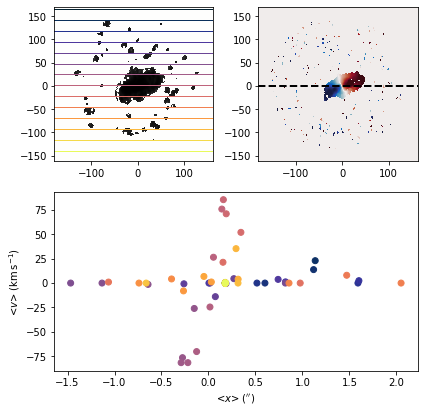

In [23]:
mydisc.plot_tw(slicing_name='N4826')

In [24]:
mydisc.slicings['N4826'].nslits

56

In [25]:
len(mydisc.slicings['N4826'].yedges), len(mydisc.slicings['N4826'].Omsini_tw)

(57, 56)

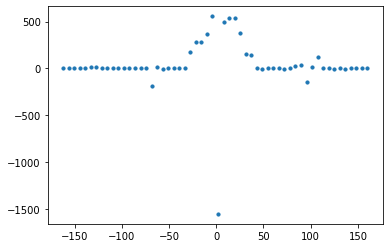

In [26]:
plt.scatter(mydisc.slicings['N4826'].yedges[1:], mydisc.slicings['N4826'].Omsini_tw, 10)
plt.show()

In [27]:
dir(mydisc.slicings['N4826'])

['Omsini_tw',
 'Omsini_tw_err',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'dfV_tw',
 'dfV_tw_err',
 'dfx_tw',
 'dfx_tw_err',
 'flux_dmapname',
 'nslits',
 'unit_Omsini_tw',
 'vel_dmapname',
 'width',
 'ycentres',
 'yedges',
 'yiter']

In [28]:
len(mydisc.slicings['N4826'].dfV_tw)

56

In [29]:
len(mydisc.slicings['N4826'].dfx_tw)

56

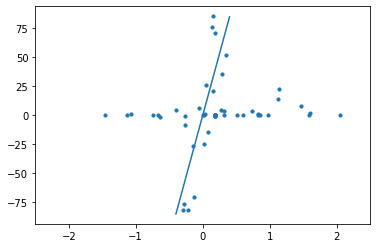

In [37]:
plt.scatter(mydisc.slicings['N4826'].dfx_tw, mydisc.slicings['N4826'].dfV_tw, 10)
plt.xlim(-2.5,2.5)
#plt.scatter(-0.25, -60, 20)
#plt.scatter(0, 40, 20)
plt.plot([-0.4, 0.4], [-85, 85])
plt.show()

In [38]:
(85+85)/0.8

212.5

In [39]:
pix_kpc = bima_scale*0.019877360925490 # kpc/pix

In [40]:
212.5*pix_kpc

4.223939196666625

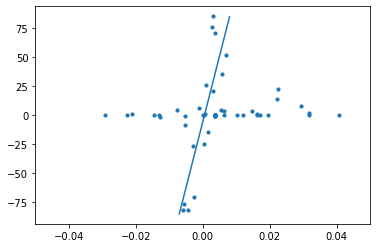

In [34]:
plt.scatter(mydisc.slicings['N4826'].dfx_tw*pix_kpc, mydisc.slicings['N4826'].dfV_tw, 10)
plt.xlim(-0.05,0.05)
# plt.scatter(-100, -20, 20)
# plt.scatter(70, 35, 20)
plt.plot([-0.007, 0.008], [-85, 85])
plt.show()

In [36]:
(85+85)/(0.007+0.008)

11333.333333333334